In [1]:
__author__ = 'Alice Jacques <alice.jacques@noirlab.edu>'
__version__ = '20241022' # yyyymmdd; 
__datasets__ = ['skymapper_dr4', 'gaia_dr3', 'sdss_dr17']
__keywords__ = ['science example']

## The SkyMapper search for extremely metal-poor stars in the Large Magellanic Cloud
https://ui.adsabs.harvard.edu/abs/2023MNRAS.524..577O/abstract  
Oh et al. 2023

https://academic.oup.com/mnras/article/489/4/5900/5568381?login=false  
Da Costa et al. 2019

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
One or two sentences, or a bullet list, of the goals of this notebook. E.g. "To find dwarf galaxies in DES DR1 images".

# Summary

**Abstract:**  
We present results of a search for extremely metal-poor (EMP) stars in the Large Magellanic Cloud (LMC), which can provide crucial information about the properties of the first stars as well as on the formation conditions prevalent during the earliest stages of star formation in dwarf galaxies. Our search utilized SkyMapper photometry, together with parallax and proper motion cuts (from Gaia), colour–magnitude cuts (by selecting the red giant branch region), and finally a metallicity-sensitive cut. Low-resolution spectra of a sample of photometric candidates were taken using the ANU 2.3m telescope/WiFeS spectrograph, from which seven stars with [Fe/H] ≤ −2.75 were identified, two of which have [Fe/H] ≤ −3. Radial velocities, derived from the Ca II triplet lines, closely match the outer rotation curve of the LMC for the majority of the candidates in our sample. Therefore, our targets are robustly members of the LMC based on their 6D phase-space information (coordinates, spectrophotometric distance, proper motions, and radial velocities), and they constitute the most metal-poor stars so far discovered in this galaxy.

**Conclusions:**  
We present results of our search for EMP stars in the LMC via SkyMapper photometry. Our photometric selection of EMP stars involved applying cuts on parallax and proper motion (from Gaia), on the colour–magnitude diagram (by selecting the RGB region), and a metallicity-sensitive cut. To confirm the EMP status of our photometric candidates, we obtained low-resolution spectra using the ANU 2.3m telescope/WiFeS spectrograph combination. We identified seven stars with [Fe/H] ≤ −2.75, including two with [Fe/H] ≤ −3. Radial velocities, derived from the Ca II triplet lines, generally match well with the outer rotation curve of the LMC for the candidates in our sample, confirming that our targets are probable LMC members. Our results constitute the most metal-poor stars found so far in the LMC. We have obtained high-resolution spectra of the most metal-poor sample and will present our findings in a future paper.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [2]:
# Standard lib
from getpass import getpass

# 3rd party imports
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc

# plots default setup
plt.rcParams['font.size'] = 14

<a class="anchor" id="auth"></a>
# Authentication
Much of the functionality of Data Lab can be accessed without explicitly logging in (the service then uses an anonymous login). But some capacities, for instance saving the results of your queries to your virtual storage space, require a login (i.e. you will need a registered user account).

If you need to log in to Data Lab, un-comment the cell below and execute it:

In [3]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'ajacques'

#### We define a little helper function to make computing 2D histograms easier.

In [4]:
def compute_nbins(x, y, binsize, extent=None):
    """Compute the needed number of x and y bins.
    
    From the x and y data, and the desired binsize (identical for x and y),
    computes the number of needed x and y bins. If 'extent' is given, trim
    x and y data to the limits given in 'extent' first. Otherwise, use the
    full data range.
    
    Parameters:
    -----------
    n, x : 1D arrays
      The x and y data to bin in 2D.
      
    binsize : float
      The desired bin size (identical for x and y), in the units of x and y.
      
    extent : tuple
      Optional. If not None, it is a 4-tuple (xmin,xmax,ymin,ymax).
      
    Returns:
    --------
    x, y : 1D arrays
      If extent=None, the returned x and y are identical to the input x and y.
      Otherwise they are trimmed to the [xmin,xmax] and [ymin,ymax] ranges
      defined in 'extent'.
    """
    
    if extent is not None:
        xmin, xmax, ymin, ymax = extent
        select = (x >= xmin) & (x <= xmax) & (y >= ymin) & (y <= ymax)
        x = x[select]
        y = y[select]
    else:
        xmin, xmax, ymin, ymax = x.min(), x.max(), y.min(), y.max()
        
    nxbins = int((xmax-xmin)/binsize)
    nybins = int((ymax-ymin)/binsize)

    return x, y, nxbins, nybins

# Query for candidates from SkyMapper DR4 and Gaia DR3
We will search for objects in the **skymapper_dr4.master** table with the following initial constraints:
- $class\_star > 0.9$
    > to ensure that the object is stellar in nature
- $flags \le 3$
    > so that there are no apparent issues with the [SExtractor](https://sextractor.readthedocs.io/en/latest/index.htmlhttps://sextractor.readthedocs.io/en/latest/index.html) photometry
- $v\_ngood \ge 2$
    > to ensure at least two measurements in the v-band
- $g\_psf \le 16.5$
    > so that the LMC candidates can be observed at high dispersion on 8m-class telescopes with sensible integration times
- $e\_g\_psf < 0.03$, $e\_i\_psf < 0.03$, and $e\_v\_psf < 0.05$ mag
    > as a compromise between photometric precision and number of candidates selected
- $ebmv\_sfd < 0.25$ mag
    > to avoid large reddening corrections to the photometry and to avoid areas of the sky where the photometry is less well calibrated and frequently affected by image crowding
- $5 \le \cos^{-1}(\sin(\delta)\sin(\delta_{c}) + \cos(\delta)\cos(\delta_{c})\cos(\alpha-\alpha_{c})) \le 20$
    > where $\delta_{c} = -69.78$ deg and $\alpha_{c} = 81.28$ deg is the center of the LMC. Limit to a region that is 5 deg to 20 deg in radius from the LMC center (to avoid crowding in the inner parts of the dwarf galaxy)
- $m_{i} \ge -0.2$
    > metallicity index cut using the metallicity-sensitive index: $m_{i} = (v − g)_0 − 1.5(g − i)_0$ (since previous studies have shown that stars with metallicity indices more negative than this value are often young stars with Ca II H+K emission, or extragalactic objects such as quasi-stellar objects and active galactic nuclei ([Da Costa et al. 2019](https://academic.oup.com/mnras/article/489/4/5900/5568381?login=false)))
- $0.7 \le (g-i)_0 \le 1.2$
    > since the RGB at lower metallicities ($[Fe/H] \le -2.5$) does not go beyond $(g-i)_{0} ~ 1.2$ mag for an old age ($\gtrsim 10$ Gyr) population. The blue color cut is applied because we want to avoid contamination from young approximately solar metallicity disc dwarfs in the bluer parts of the CMD

And crossmatch our objects with the **gaia_dr3.gaia_source** table with the following constraints:
- $-0.2'' \le \pi \le 0.2''$
    > parallax between -0.2'' and 0.2''
- $\sqrt{1.7(\mu_{\alpha} - 1.80)^{2} + 0.8(\mu_{\delta} - 0.37)^{2}} \le 1.0$
    > this equation was determined quantitatively, where they measured the average proper motion and spread for stars located 2 deg - 6 deg from the LMC center (to avoid kinematics from the core and contamination from the Milky Way Halo)
  
## **Constraints applied in the paper but not applied in this notebook (because the column does not exist in SkyMapper DR4):**
- `nch_max = 1` so that there is a single source for each filter
- `ngood_min >= 1` to ensure at least one measurement in all of ugriz
- `prox > 7.5 AND twomass_dist2 > 7.5` so that there is no other DR1.1 or additional 2MASS source within 7.5 arcsec of the target (these columns aren't in skymapper dr4? use self_dist2 and gaia_dr3_dist2 instead?)

In [5]:
query = """
SELECT
    s.object_id AS smss_id, s.gaia_dr3_id1 AS gaia_id, s.raj2000 as ra, s.dej2000 as dec,
    s.g_psf, s.i_psf, s.v_psf, ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) AS g_i0,
    (s.g_psf - 2.986 * s.ebmv_sfd) AS g0, ((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) AS v_g0,
    s.ebmv_sfd, s.radius,
    (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd)) AS metallicity,
    (ATAN((81.28*(PI()/180) - s.raj2000*(PI()/180))/(-69.78*(PI()/180) - s.dej2000*(PI()/180))))*(180/PI()) AS angle,
    g.parallax, g.pmra, g.pmdec
FROM
    (SELECT *, q3c_dist(raj2000, dej2000, 81.28, -69.78) as radius
     FROM skymapper_dr4.master
     WHERE q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 20)
     AND not q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 5)
     ) AS s
JOIN
    gaia_dr3.gaia_source AS g ON s.gaia_dr3_id1 = g.source_id
WHERE
    s.class_star > 0.9
    AND s.flags <= 3
    AND s.v_ngood >= 2
    AND s.g_psf >= 16.5
    AND s.e_g_psf < 0.03
    AND s.e_i_psf < 0.03
    AND s.e_v_psf < 0.05
    AND s.ebmv_sfd < 0.25
    AND s.g_psf != 'NaN'
    AND s.i_psf != 'NaN'
    AND s.v_psf != 'NaN'
    AND s.gaia_dr3_dist2 > 7.5
    AND s.self_dist2 > 7.5
    AND -0.2 <= (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd))
    AND ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) BETWEEN 0.7 AND 1.2
    AND g.parallax BETWEEN -0.2 AND 0.2
    AND SQRT(1.7*POWER(g.pmra - 1.80, 2) + 0.8*POWER(g.pmdec - 0.37, 2)) <= 1.0
"""
print(query)


SELECT
    s.object_id AS smss_id, s.gaia_dr3_id1 AS gaia_id, s.raj2000 as ra, s.dej2000 as dec,
    s.g_psf, s.i_psf, s.v_psf, ((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd) AS g_i0,
    (s.g_psf - 2.986 * s.ebmv_sfd) AS g0, ((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) AS v_g0,
    s.ebmv_sfd, s.radius,
    (((s.v_psf - s.g_psf) - 1.04 * s.ebmv_sfd) - 1.5*((s.g_psf - s.i_psf) - 1.5 * s.ebmv_sfd)) AS metallicity,
    (ATAN((81.28*(PI()/180) - s.raj2000*(PI()/180))/(-69.78*(PI()/180) - s.dej2000*(PI()/180))))*(180/PI()) AS angle,
    g.parallax, g.pmra, g.pmdec
FROM
    (SELECT *, q3c_dist(raj2000, dej2000, 81.28, -69.78) as radius
     FROM skymapper_dr4.master
     WHERE q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 20)
     AND not q3c_radial_query(raj2000, dej2000, 81.28, -69.78, 5)
     ) AS s
JOIN
    gaia_dr3.gaia_source AS g ON s.gaia_dr3_id1 = g.source_id
WHERE
    s.class_star > 0.9
    AND s.flags <= 3
    AND s.v_ngood >= 2
    AND s.g_psf >= 16.5
    AND s.e_g_psf < 0.03
    AN

In [6]:
qc.query(sql=query, out='mydb://skymapperdr4_x_gaiadr3', drop=True, timeout=600)

'OK'

In [7]:
res = qc.query(sql="select * from mydb://skymapperdr4_x_gaiadr3", fmt='pandas', timeout=600)
print(f"Number of objects: {len(res)}")

Number of objects: 1059


| object_id | disqualified reason       | Rule  |
|-----------|---------------------------|-------|
| 500263380 | `v_ngood = 1`                | `v_ngood >= 2`   |
| 471915910 | `flags = 2048`                | `flags <= 3`   |
| 497519424 | `gaia_dr3_dist2 = 1.66`       | `gaia_dr3_dist2 > 7.5`   |
| 500382880 | `gaia_dr3_dist2 = 3.1`        | `gaia_dr3_dist2 > 7.5`   |
| 500287810 | `g_psf = 16.3745` ; `v_ngood = 1` | `g_psf >= 16.5` ; `v_ngood >= 2`   |
| 500766372 | `gaia_dr3_dist2 = 7.15`       | `gaia_dr3_dist2 > 7.5`   |

Above: objects from the final selection in the paper that were NOT selected in this notebook for the reasons stated in the table.

## Metallicity-sensitive diagram and CMD

In [8]:
# Extracted X,Y values for Dartmouth isochrones from Figure 1 using https://apps.automeris.io/wpd/
### THIS CELL CAN BE DELETED
x_FeH_4_mi=[0.70,0.7110,0.7190,0.7271,0.7352,0.7432,0.7513,0.7594,0.7674,0.7755,0.7835,0.7916,0.7997,0.8077,0.8158,0.8239,0.8319,0.8400,0.8480,0.8561,0.8642,0.8722,0.8803,0.8884,0.8964,0.9045,0.9125,0.9206,0.9287,0.9367,0.9448,0.9529,0.9609,0.9690,0.9771,0.9851,0.9932,0.9990]
y_FeH_4_mi=[0.01907,0.01959,0.02022,0.02045,0.02137,0.02217,0.02292,0.02378,0.02486,0.02567,0.02647,0.02761,0.02870,0.03001,0.03127,0.03252,0.03400,0.03554,0.03725,0.03868,0.03999,0.04176,0.04347,0.04501,0.04660,0.04831,0.04997,0.05179,0.05322,0.05464,0.05618,0.05783,0.05920,0.06057,0.06189,0.06320,0.06451,0.06570]
x_4_mi = np.linspace(0.7,1.0,100)
FeH_4_mi = 0.219*(x_4_mi**2) - 0.2053*x_4_mi + 0.0539

x_FeH_2_mi =[0.70,0.7120,0.7201,0.7281,0.7362,0.7443,0.7523,0.7604,0.7685,0.7765,0.7846,0.7927,0.8007,0.8088,0.8169,0.8249,0.8330,0.8411,0.8491,0.8572,0.8653,0.8733,0.8814,0.8895,0.8975,0.9056,0.9137,0.9218,0.9298,0.9379,0.9460,0.9540,0.9621,0.9702,0.9783,0.9863,0.9944,1.002,1.011,1.019,1.027,1.035,1.043,1.051,1.059,1.067,1.075,1.083,1.091,1.099,1.107,1.116,1.124,1.132,1.140,1.148,1.156]
y_FeH_2_mi = [0.1433,0.1425,0.1423,0.1429,0.1442,0.1463,0.1486,0.1513,0.1545,0.1580,0.1614,0.1646,0.1682,0.1717,0.1754,0.1789,0.1824,0.1861,0.1901,0.1941,0.1980,0.2022,0.2068,0.2113,0.2156,0.2204,0.2251,0.2298,0.2343,0.2393,0.2443,0.2493,0.2544,0.2596,0.2650,0.2704,0.2758,0.2813,0.2868,0.2924,0.2980,0.3037,0.3094,0.3152,0.3211,0.3269,0.3327,0.3386,0.3445,0.3504,0.3564,0.3625,0.3685,0.3747,0.3806,0.3867,0.3924]
x_2_mi = np.linspace(0.7,1.2,100)
FeH_2_mi = 0.0246*np.exp(2.4172*x_2_mi)

x_FeH_4_g = [0.8703927,0.8751304,0.8795037,0.8838770,0.8882502,0.8926235,0.8969968,0.9013700,0.9057433,0.9101165,0.9144898,0.9192275,0.9243297,0.9294318,0.9345339,0.9396361,0.9451027,0.9509337,0.9567647,0.9629602,0.9695201,0.9760799,0.9826398,0.9891997,0.9961241,1.001226]
y_FeH_4_g = [16.99999,16.97275,16.95185,16.93184,16.91213,16.89213,16.87256,16.85300,16.83344,16.81447,16.79551,16.77535,16.75427,16.73357,16.71453,16.69638,16.67704,16.65772,16.63840,16.61887,16.59864,16.57931,16.56077,16.54232,16.52300,16.50956]
x_4_g = np.linspace(0.7,1.0,100)
FeH_4_g = 10.156*(x_4_g**2) - 22.731*x_4_g + 29.089

x_FeH_2_g = [0.9684743,0.9757155,0.9811821,0.9866487,0.9924797,0.9983107,1.004142,1.010337,1.016533,1.022728,1.029288,1.035848,1.042772,1.050061,1.057350,1.064639,1.071927,1.079216,1.086505,1.094158,1.102176,1.110193,1.118211,1.126229,1.134246,1.142264,1.150282,1.158299,1.166317,1.174335,1.182352,1.188912]
y_FeH_2_g = [16.99899,16.97314,16.95385,16.93449,16.91473,16.89507,16.87575,16.85608,16.83645,16.81769,16.79885,16.78011,16.76079,16.74100,16.72121,16.70168,16.68251,16.66406,16.64498,16.62600,16.60648,16.58696,16.56745,16.54793,16.52842,16.51036,16.49158,16.47352,16.45571,16.43798,16.42065,16.40632]
x_2_g = np.linspace(0.7,1.2,100)
FeH_2_g = 3.0952*(x_2_g**2) - 9.3219*x_2_g + 23.118

#### Equations for isochrones obtained from X,Y values

In [9]:
x_2_mi = np.linspace(0.7,1.2,100)
FeH_2_mi = 0.0246*np.exp(2.4172*x_2_mi)
x_4_mi = np.linspace(0.7,1.0,100)
FeH_4_mi = 0.219*(x_4_mi**2) - 0.2053*x_4_mi + 0.0539

x_2_g = np.linspace(0.7,1.2,100)
FeH_2_g = 3.0952*(x_2_g**2) - 9.3219*x_2_g + 23.118
x_4_g = np.linspace(0.7,1.0,100)
FeH_4_g = 10.156*(x_4_g**2) - 22.731*x_4_g + 29.089

#### Select only the objects that are above the [Fe/H]=-2 Dartmouth isochrone

In [10]:
c1 = res['metallicity'] < np.interp(res['g_i0'], x_2_mi, FeH_2_mi)
count=0
for i in c1:
    if i is True:
        count = count+1
print(f"Final EMP candidate count: {count}")

Final EMP candidate count: 243


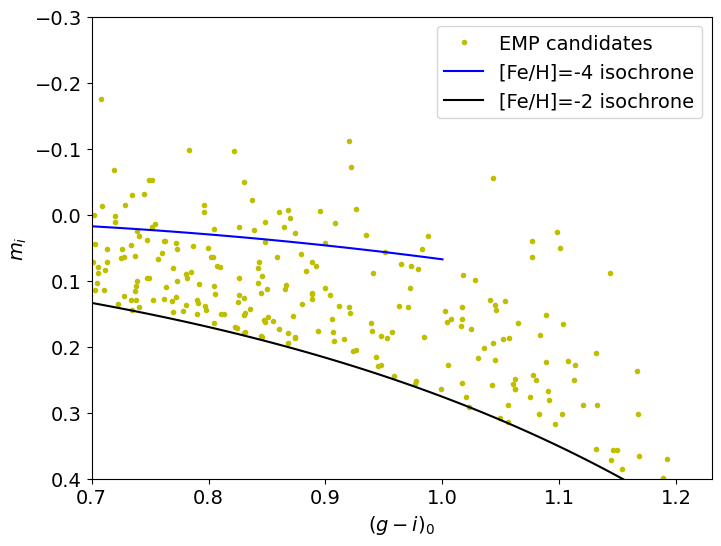

In [11]:
plt.figure(figsize=(8,6))
plt.plot(res['g_i0'][c1],res['metallicity'][c1],'y.',label='EMP candidates')
plt.plot(x_4_mi,FeH_4_mi,'b-',label='[Fe/H]=-4 isochrone')
plt.plot(x_2_mi,FeH_2_mi,'k-',label='[Fe/H]=-2 isochrone')
plt.xlim(0.7,1.23)
plt.ylim(0.4,-0.3) # Figure 1 has these limits
plt.ylabel('$m_i$')
plt.xlabel('$(g - i)_0$')
plt.legend(loc='upper right')
plt.show()

Metallicity-sensitive diagram showing the Magellanic EMP candidates from our final adopted selection. The blue and black curves represent [Fe/H] = −4 and −2 Dartmouth isochrones for an age of 12.5 Gyr and $[\alpha/Fe]=0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)). Both isochrones have been calibrated with reference to the SkyMapper DR3 data as described in [Da Costa et al. (2019)](https://academic.oup.com/mnras/article/489/4/5900/5568381?login=false). The upper (positive) bound on the metallicity index selection was set by the location of the [Fe/H]=-2 Dartmouth isochrone for an age of 12.5 Gyr and $[\alpha/H]=0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)).

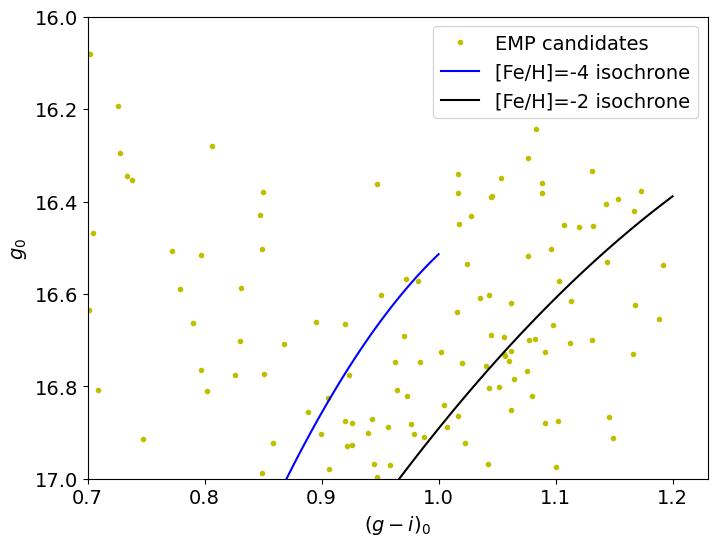

In [12]:
plt.figure(figsize=(8,6))
plt.plot(res['g_i0'][c1],res['g0'][c1],'y.',label='EMP candidates')
plt.plot(x_4_g,FeH_4_g,'b-',label='[Fe/H]=-4 isochrone')
plt.plot(x_2_g,FeH_2_g,'k-',label='[Fe/H]=-2 isochrone')
plt.xlim(0.7,1.23)
plt.ylim(17.0, 16.0) # Figure 1 has these limits
plt.ylabel('$g_0$')
plt.xlabel('$(g - i)_0$')
plt.legend(loc='upper right')
plt.show()

CMD showing the Magellanic EMP candidates from our final adopted selection. The blue and black curves represent [Fe/H] = −4 and −2 Dartmouth isochrones for an age of 12.5 Gyr and $[\alpha/Fe]=0.4$ ([Dotter et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJS..178...89D/abstract)). Both isochrones have been calibrated with reference to the SkyMapper DR3 data as described in [Da Costa et al. (2019)](https://academic.oup.com/mnras/article/489/4/5900/5568381?login=false). The isochrones have been shifted in distance modulus by 18.5 to match the LMC distance.

## Radial velocity vs position angle
Here we obtain the radial velocity values from the `sdss_dr17.apogee2_allstar` table

In [13]:
query_rv = """
SELECT
    S.*, A.hrv, A.rv_feh, A.teff, A.logg, A.rv_teff, A.rv_logg
FROM
    mydb://skymapperdr4_x_gaiadr3 AS S
JOIN
    sdss_dr17.apogee2_allstar AS A ON S.gaia_id = A.gaiaedr3_source_id
"""
print(query_rv)


SELECT
    S.*, A.hrv, A.rv_feh, A.teff, A.logg, A.rv_teff, A.rv_logg
FROM
    mydb://skymapperdr4_x_gaiadr3 AS S
JOIN
    sdss_dr17.apogee2_allstar AS A ON S.gaia_id = A.gaiaedr3_source_id



In [14]:
qc.query(sql=query_rv, out='mydb://skymapperdr4_x_gaiadr3_x_apogee2', drop=True, timeout=600)

'OK'

In [15]:
final = qc.query(sql="select * from mydb://skymapperdr4_x_gaiadr3_x_apogee2", fmt='pandas', timeout=600)
final

,smss_id,gaia_id,ra,dec,g_psf,i_psf,v_psf,g_i0,g0,v_g0,...,angle,parallax,pmra,pmdec,hrv,rv_feh,teff,logg,rv_teff,rv_logg
0,462684998,5260725503217798144,96.404624,-75.905938,17.0498,16.1668,18.8146,0.756251,16.797484,1.676919,...,-67.950538,0.189620,1.481980,1.325902,214.2744,-0.9478,4776.4,2.473,4912.28,3.136060
1,464286279,5261494783400104192,95.097942,-75.667642,16.9479,15.8485,18.6335,0.970551,16.691403,1.596262,...,-66.921789,-0.013830,1.704686,1.022928,277.5191,-2.5000,4559.4,0.887,4510.79,1.647123
2,464605314,5281655944004539264,103.494390,-67.154899,16.5460,15.3105,18.4580,1.083249,16.242921,1.806441,...,83.260544,0.027971,1.399954,1.169490,330.2869,-2.4240,4500.1,0.694,4464.59,1.345082
3,464781416,5284893971387283456,99.331650,-64.126203,16.5350,15.3888,18.3093,1.053050,16.349569,1.709716,...,72.609385,0.033367,1.764923,1.079426,331.0191,-2.1670,4491.1,0.661,4494.06,1.477748
4,464795749,5477109391564157952,98.466843,-63.657704,17.2016,16.2016,18.9175,0.904900,17.012287,1.649964,...,70.393088,0.045120,1.610301,1.019161,323.5758,-2.0270,4660.4,1.310,4628.59,2.013458
5,464789936,5284934756396797184,98.446875,-64.062684,17.3337,16.3681,18.7093,0.869601,17.142596,1.309039,...,71.579998,-0.027780,1.539075,1.059221,320.2577,-2.5000,4683.3,1.094,4628.92,2.466324
6,464797583,5477182302928881024,98.127155,-63.308821,16.9294,16.1105,18.4794,0.729499,16.751434,1.488017,...,68.987664,0.042267,1.951489,0.021114,150.6798,-1.0435,4872.4,2.322,5076.90,3.167504
7,464798479,5477154604682965888,97.918629,-63.645246,17.2324,16.3008,18.6310,0.843551,17.057123,1.337552,...,69.760792,0.024576,1.515690,0.943366,349.5936,-2.3689,4757.9,1.615,4655.95,1.916760
8,490840412,4623182962981075968,84.986273,-79.683403,16.7782,15.8998,18.4227,0.739800,16.502294,1.548405,...,-20.517978,0.003405,1.254946,0.245479,85.4528,-1.3109,NaN,NaN,4886.87,2.803806
9,491449548,4637858591353195776,25.697951,-74.749972,16.8687,15.8563,18.5799,0.933050,16.710741,1.656185,...,84.890380,0.047090,1.407164,-0.387177,201.3016,-1.4780,4655.6,1.826,4654.75,2.453694


In [16]:
# Extracted X,Y values for LMC rotation model from Figure 3 using https://apps.automeris.io/wpd/
### THIS CELL CAN BE DELETED
x_rot = [-198.9599774,-198.0313388,-195.6740254,-192.9595434,-190.1021938,-187.2448443,-184.2446273,-181.1015428,-177.9584583,-174.8153738,-171.6722893,-168.5292048,-165.3861203,-162.2430358,-159.0999513,-155.9568668,-152.8137824,-149.6706979,-146.5276134,-143.3845289,-140.2414444,-137.0983599,-133.9552754,-130.8121909,-127.6691064,-124.5260219,-121.3829374,-118.239853,-115.0967685,-111.953684,-108.8105995,-105.667515,-102.5244305,-99.38134601,-96.23826152,-93.09517703,-89.95209254,-86.80900805,-83.66592356,-80.52283907,-77.37975458,-74.23667009,-71.0935856,-67.9505011,-64.80741661,-61.8071996,-58.94985006,-56.09250053,-53.37801847,-50.66353641,-47.94905435,-45.37743976,-42.80582518,-40.2342106,-37.66259601,-35.09098143,-32.51936685,-29.94775226,-27.37613768,-24.8045231,-22.23290851,-19.66129393,-17.08967935,-14.51806476,-11.8035827,-8.946233165,-6.088883628,-3.231534091,-0.231317077,2.911767414,6.054851904,9.197936395,12.34102089,15.48410538,18.62718987,21.77027436,24.91335885,28.05644334,31.19952783,34.34261232,37.48569681,40.6287813,43.77186579,46.91495028,50.05803477,53.20111927,56.34420376,59.48728825,62.63037274,65.77345723,68.91654172,72.05962621,75.2027107,78.34579519,81.48887968,84.63196417,87.77504866,90.91813315,94.06121765,97.20430214,100.3473866,103.4904711,106.6335556,109.7766401,112.9197246,116.0628091,119.2058936,122.2061106,125.0634601,127.9208097,130.6352917,133.3497738,136.2071233,138.9216054,141.49322,144.0648345,146.6364491,149.2080637,151.7796783,154.3512929,156.9229075,159.7283052]
y_rot = [217.5621729,215.4580922,213.0583471,209.4209983,205.7604478,202.065952,198.4727207,194.726164,191.041326,187.6805115,184.3814157,181.2674762,178.3695523,175.5950659,173.0520248,170.7095697,168.5831301,166.6727062,164.9937276,163.515335,162.252958,161.2528856,160.4842586,159.9779363,159.6413405,159.5516197,159.8476411,160.2825297,160.9180043,161.8312132,162.9912971,164.3673966,165.9286524,167.7676426,169.838078,172.0782401,174.5344177,177.206611,180.0485309,183.0447476,186.2878393,189.6080795,193.2677728,196.9891848,200.7105969,204.3477171,208.0532994,211.8097997,215.4122317,219.137244,222.8584846,226.450173,230.0984368,233.7467007,237.3572476,241.02437,244.6726339,248.3397563,252.1011712,255.7494351,259.359982,263.0271044,266.6565098,270.1727641,273.8374292,277.6618201,281.3674024,285.0729847,288.710105,292.431517,296.1374993,299.581177,302.9014172,306.0519308,309.0327178,311.8129189,314.4388231,316.8178524,319.0117253,320.9895827,322.7514244,324.2663911,325.5807719,326.6637074,327.4843382,328.0735236,328.4621232,328.5266993,328.4678379,328.0540937,327.4860526,326.6557068,325.5630563,324.2698199,322.7142789,320.9581518,319.0014389,316.7824212,314.393677,311.7734875,308.9681417,306.0084991,302.8328408,299.4874559,296.049493,292.318366,288.5718092,284.9446326,281.2331641,277.4877504,273.8918903,270.184765,266.2696246,262.4304898,258.8182285,255.1682502,251.4994134,247.7740011,244.1051643,240.3986105,236.6920566,233.4954618]

#### Equation for LMC rotation model from van der Marel+2002

In [17]:
x_rots = np.linspace(-200,150,100)
rots = 7e-10*(x_rots**5) + 1e-07*(x_rots**4) - 6e-05*(x_rots**3) - 0.0061*(x_rots**2) + 1.2142*(x_rots) + 288.47

#### Radial velocity and position angle values from Oh et al 2023:

In [18]:
data_oh = {'angle': [-0.1,43.7,13.3,34.9,-31.2,-0.5,-66.0,2.8,-17.4,-70.2],
        'rv': [312.0,352.9,289.5,283.6,286.5,269.3,232.1,284.6,229.7,307.4]}
df_oh = pd.DataFrame(data_oh)

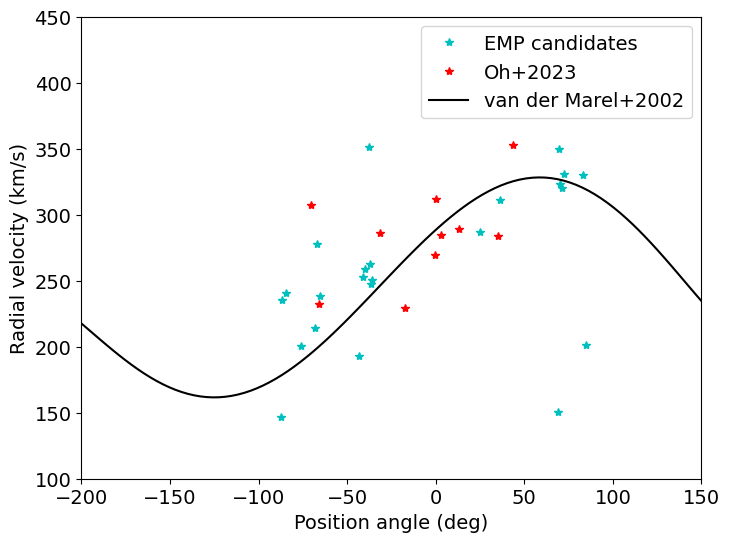

In [19]:
plt.figure(figsize=(8,6))
plt.plot(final['angle'], final['hrv'], 'c*', label='EMP candidates')
plt.plot(df_oh['angle'], df_oh['rv'], 'r*', label='Oh+2023')
plt.plot(x_rots, rots, 'k-', label='van der Marel+2002')
plt.xlim(-200, 150)
plt.ylim(100, 450)
plt.ylabel('Radial velocity (km/s)')
plt.xlabel('Position angle (deg)')
plt.legend()
plt.show()

The Figure shows radial velocity as a function of position angle in the LMC (measured east of north) for our LMC sample. The black sinusoid shows the LMC rotation model derived from carbon stars in the outer LMC disc ([van der Marel et al. 2002](https://arxiv.org/abs/astro-ph/0205161)) that sit at radii similar to the majority of our EMP sample.